<a href="https://colab.research.google.com/github/intel-analytics/BigDL/blob/branch-2.0/python/orca/colab-notebook/examples/fashion_mnist_bigdl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import sys
import os

In [27]:
os.environ["SPARK_HOME"]="/Users/phuonglh/spark-2.4.6-bin-hadoop2.7/" # use the same version as installed pyspark package

## **BigDL using Orca APIs**

In this guide we will describe how to scale out standard (single node) PyTorch programs using Orca and visualize the results with Tensorboard in 5 simple steps.

In [28]:
#import necessary libraries and modules
from __future__ import print_function

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

In [29]:
print(os.environ["JAVA_HOME"])

/Library/Java/JavaVirtualMachines/jdk1.8.0_92.jdk/Contents/Home


### **Step 1: Init Orca Context**


In [30]:
# recommended to set it to True when running BigDL in Jupyter notebook. 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cores=4, memory="2g") # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=4) # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(
        cluster_mode="yarn-client", cores=4, num_nodes=2, memory="2g",
        driver_memory="10g", driver_cores=1,
        conf={"spark.rpc.message.maxSize": "1024",
              "spark.task.maxFailures": "1",
              "spark.driver.extraJavaOptions": "-Dbigdl.failure.retryTimes=1"}) # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /Users/phuonglh/miniconda3/envs/BDL/lib/python3.7/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /Users/phuonglh/miniconda3/envs/BDL/lib/python3.7/site-packages/bigdl/share/core/lib/all-2.3.0.jar:/Users/phuonglh/miniconda3/envs/BDL/lib/python3.7/site-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.3.0-jar-with-dependencies.jar:/Users/phuonglh/miniconda3/envs/BDL/lib/python3.7/site-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.3.0-jar-with-dependencies.jar --driver-class-path /Users/phuonglh/miniconda3/envs/BDL/lib/python3.7/site-packages/bigdl/share/core/lib/all-2.3.0.jar:/Users/phuonglh/miniconda3/envs/BDL/lib/python3.7/site-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.3.0-jar-with-dependencies.jar:/Users/phuonglh/miniconda3/envs/BDL/lib/python3.7/site-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.3.0-jar-with-dependencies.jar

[2024-05-31 18:53:35] INFO     log path /tmp/bigdlb60df89b-2653-4444-a696-72d35c15d29f.log


2024-05-31 18:53:35,648 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2024-05-31 18:53:35,649 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2024-05-31 18:53:35,649 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2024-05-31 18:53:35,650 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
24-05-31 18:53:35 [Thread-3] INFO  Engine$:122 - Auto detect executor number and executor cores number
24-05-31 18:53:35 [Thread-3] INFO  Engine$:124 - Executor number is 1 and executor cores number is 4
24-05-31 18:53:35 [Thread-3] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 14
2024-05-31 18:53:35 WARN  SparkContext:66 - Using an existing SparkContext; some configuration may not take effect.
24-05-31 18:53:35 [Thread-3] INFO  Engine$:461 - Find existing spark context. Checking the spark conf...
Successfully got a SparkContext


### **Step 2: Define the Model**
Define a model, loss and optimizer in the same way as in any standard (single node) PyTorch program.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

def createModel(config):
    model = Net()
    return model

def createOptimizer(model, config):
    return torch.optim.Adam(model.parameters(), lr=config.get("lr", 0.001))

criterion = nn.NLLLoss()

### **Step 3: Define Train Dataset**

Define the dataloader using standarad `torch.utils.data.DataLoader` and put into dataset.

In [32]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# create train_dataloader 
trainset = torchvision.datasets.FashionMNIST('./dat', download=True, train=True, transform=transform)
def trainLoader(config, batch_size):
  return torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# create test_dataloader
testset = torchvision.datasets.FashionMNIST(root='./dat', train=False, download=True, transform=transform)
def testLoader(config, batch_size):
  return torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


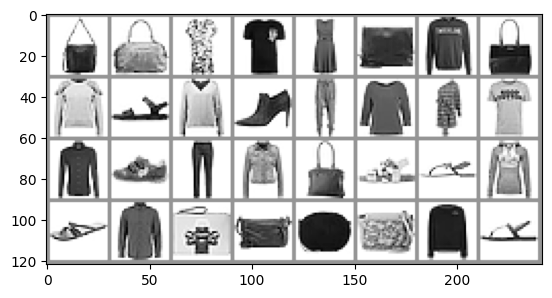

In [34]:
#constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# plot some random training images
training = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
dataIter = iter(training)
images, labels = next(dataIter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)


### **Step 4: Fit with Orca Estimator**

First, create an Estimator and set its backend to `spark` (default).


In [35]:
from bigdl.orca.learn.pytorch import Estimator
from bigdl.orca.learn.metrics import Accuracy

estimator = Estimator.from_torch(model=createModel, optimizer=createOptimizer, loss=criterion, metrics=[Accuracy()], use_tqdm=True, model_dir="bin/")

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Next, fit using the Estimator.

In [36]:
batch_size = 64
epochs = 10
estimator.fit(data=trainLoader, epochs=epochs, validation_data=testLoader)
estimator.save("bin/fashion-mnist")

[Stage 5:>                                                          (0 + 1) / 1][2024-05-31 18:53:42] INFO     cluster is: ['localhost:55097']
[2024-05-31 18:53:42] INFO     Added key: store_based_barrier_key:1 to store for rank: 0
[2024-05-31 18:53:42] INFO     Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 1 nodes.
1/10e:   0%|          | 0/1875 [00:00<?, ?batch/s][W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)

User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_A

'bin/fashion-mnist'

Finally, evaluate using the Estimator. 

In [37]:
result = estimator.evaluate(data=testLoader)
print("Accuracy of the network on the test images: %s" % result)

[Stage 9:>                                                          (0 + 1) / 1][W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
1/1e:   0%|          | 0/313 [00:00<?, ?batch/s]
User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_MONOTONIC

Accuracy of the network on the test images: {'num_samples': 10000, 'Accuracy': tensor(0.8952), 'val_loss': 0.2923210466146469}


In [38]:
# stop orca context when program finishes
stop_orca_context()

Stopping orca context
